# Problema de clasificación de imágenes multi-espectrales

## Javier Orduña Rubio


**Se plantea una aplicación de clasificación de imágenes multi-espectrales de satélite en la cual se dispone de un conjunto de muestras etiquetadas con sus clases correspondientes. De este modo, vamos a ir dividiendo los diferentes pasos de las soluciones propuestas pequeños apartados, indicando al principio de cada uno de ellos lo que se pretende hacer en negrita.**

Una de las características importantes de las imágenes de satélite suele ser el gran volumen de datos que se maneja (aumenta de forma cuadrática con las dimensiones espaciales y lineal con el número de bandas o canales). La otra suele ser el reducido número de muestras etiquetadas de las que se dispone, debido al coste que supone etiquetar las muestras. Por eso mismo vamos a abordar el problema de forma no supervisada empleando todos los datos (clustering) y de forma supervisada pero empleando un subconjunto de datos etiquetados reducido (clasificación). 

En todos los casos, aunque tratemos con imágenes, consideraremos que la información relevante se encuentra en el espectro de cada pixel y no hay que utilizar relaciones espaciales entre pixeles. Es decir, cada pixel es una muestra.


**Vamos a comenzar usando algún algoritmo de clustering sobre todos los datos sin emplear las etiquetas para obtener una primera clasificación.** Así, definiremos una estrategia para clasificar nuevos ejemplos y obtener el mapa de clasificación final de toda la imagen. Obviamente, al no haber empleado las etiquetas de las clases puede que nuestro mapa de clasificación basado en clustering no tenga mucha relación con las clases predefinidas.

En primer lugar vamos a cargar nuestros datos y a observar sus dimensiones para ver cómo representarlos posteriormente.

In [2]:
import numpy as np
import scipy.io.matlab as matlab
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
import skfuzzy as fuzz
from sklearn import metrics
from time import time
from sklearn.metrics import silhouette_samples, adjusted_rand_score, mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score, homogeneity_score, completeness_score, v_measure_score,fowlkes_mallows_score,silhouette_score, calinski_harabasz_score
from sklearn.metrics import classification_report
from sklearn.metrics.cluster import contingency_matrix
from sklearn.mixture import GaussianMixture
import matplotlib.cm as cm
from sklearn.utils import resample
from scipy.stats import mode

In [5]:
# Lectura de la imagen de fichero de Matlab .mat
mat_file =  "datasetB5.mat"
mat = matlab.loadmat(mat_file,squeeze_me=True) #devuelve un dictionary
list(mat.keys()) #variables almacenadas

X = mat["X"]   #imagen (hipercubo 3D: filas x columnas x variables) 
Xl = mat["Xl"]   #muestras etiquetadas (muestas x variables) 
Yl = mat["Yl"]   #etiquetas de clases (muestras x 1, 0=sin clase)
# Reshape del Ground Truth como una imagen
Y = np.reshape(Yl, (X.shape[0], X.shape[1]),order="F")

print("Tenemos ", np.unique(Yl).size, "etiquetas diferentes, que son ", np.unique(Yl))
print('Dimensiones de X:',X.shape)
print('Dimensiones de Xl:',Xl.shape)
print('Dimensiones de Y:',Y.shape)
print('Dimensiones de Yl:',Yl.shape)

values, counts = np.unique(Yl, return_counts=True)
for i in range(len(list(values))):
    print(f'Hay {counts[i]} elementos de la clase {values[i]}')

Tenemos  2 etiquetas diferentes, que son  [0 1]
Dimensiones de X: (321, 493, 15)
Dimensiones de Xl: (158253, 15)
Dimensiones de Y: (321, 493)
Dimensiones de Yl: (158253,)
Hay 85819 elementos de la clase 0
Hay 72434 elementos de la clase 1


Observamos que tenemos una imagen hiperespectral de 15 capas, que se almacena en X. Como cada píxel es considerado como una muestra, en Xl reorganizamos la imagen hiperespectral poniendo cada una de las imágenes, es decir, cada una de las variables, en una columna. Por tanto, la dimensión de Xl es (núm. muestras, variables). En Y se almacenan las etiquetas de cada uno de los píxeles (hay por tanto 321·493 = 158253 etiquetas), que pueden ser de dos tipos: 0 y 1. Yl simplemente es una reorganización de Y, de modo que su dimensión es (núm. muestras,). Podemos ver también que se tiene que las dos clases están bastante balanceadas, con un número ligeramente superior de elementos de la clase 0. Por tanto, no será necesario realizar un balanceo de las clases.

Para hacernos una idea del problema, representemos una de las 15 capas de la imagen hiperespectral junto con las etiquetas almacenadas en Yl

(<matplotlib.image.AxesImage at 0x1b81c059e50>,
 (-0.5, 492.5, 320.5, -0.5),
 Text(0.5, 1.0, 'Ground Truth'))

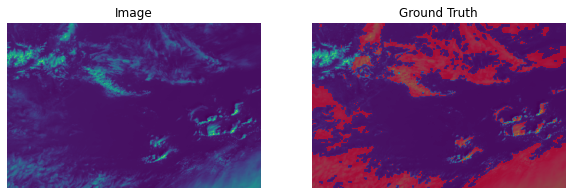

In [3]:
clasmap=Y; 
clasmap_masked = np.ma.masked_where(clasmap<1,clasmap)

plt.figure(figsize=(10,10))
ax=plt.subplot(1,2,1)
ax.imshow(X[:,:,0]), ax.axis('off'), plt.title('Image') #Cogemos la primera de las capas
ax=plt.subplot(1,2,2)
ax.imshow(X[:,:,1])
ax.imshow(clasmap_masked, cmap = 'hsv', alpha = 0.5), ax.axis('off'), plt.title('Ground Truth')

Como vemos, tenemos una imagen hiperespectral de nubes. Las etiquetas nos indican las zonas de la imagen donde se encuentran estas nubes.

Una vez hemos visto esto, apliquemos algún algoritmo de clústering para obtener una clasificación de la imagen hiperespectral sin usar las etiquetas. En primer lugar, nos planteamos cuántos clusters debemos elegir para clasificar los datos, o lo que es lo mismo, cuantas etiquetas diferentes tenemos. En nuestro caso, conocemos los datos y sabemos que son dos el número de etiquetas diferentes, pero si estuviésemos en la situación de un caso desconocido hay que plantearse cuál es el número óptimo de clusters. 

Para elegir el número óptimo de clusters usamos el coeficiente de Silhouette. El coeficiente de Silhouette o valor de la silueta es una medida de cuán similar es un objeto a su propio cúmulo (cohesión) en comparación con otros cúmulos (separación). La silueta va de -1 a +1, donde un valor alto indica que el objeto está bien emparejado con su propio cúmulo y mal emparejado con los cúmulos vecinos. Si la mayoría de los objetos tienen un valor alto, entonces la configuración del cúmulo es apropiada. Si muchos puntos tienen un valor bajo o negativo, entonces la configuración de cúmulos puede tener demasiados o muy pocos cúmulos *(Wikipedia)*.

Así, calcularemos el valor de la silueta para diferentes números de clusters utilizando para clasificar el algoritmo de clustering Kmeans de sklearn.


n_clusters =2, Av. silh=0.733
n_clusters =3, Av. silh=0.656
n_clusters =4, Av. silh=0.655


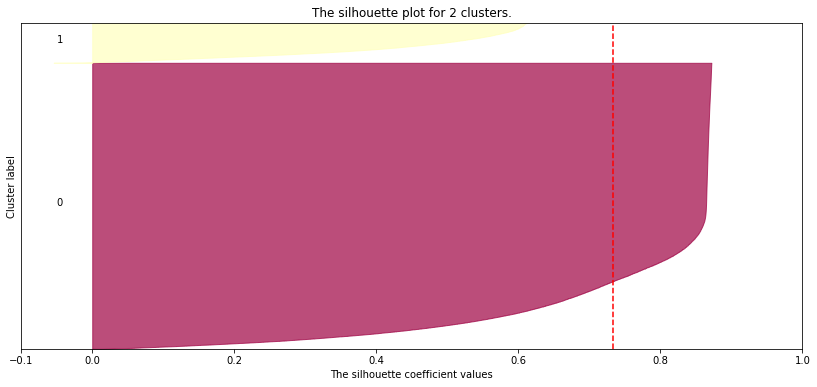

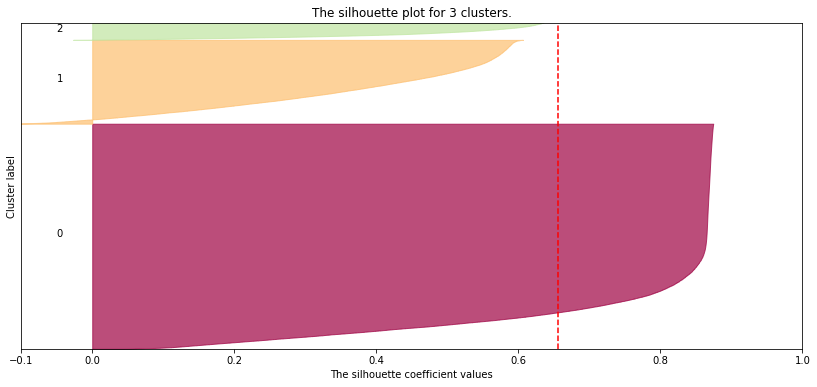

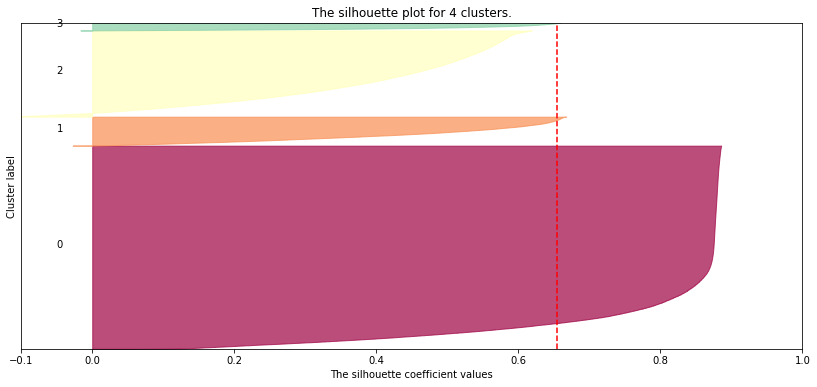

In [5]:
range_n_clusters = [2, 3, 4, ]

silouettes = []
calinskis  = []
cms = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig,ax = plt.subplots()
    fig.set_size_inches(14, 6)

    # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, 
    #to demarcate them clearly.
    ax.set_ylim([0, len(Xl) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(Xl)    

    # The silhouette_score gives the average value for all the samples.This gives a perspective into the density and separation
    #of the formed clusters    
    silhouette_avg = silhouette_score(Xl, cluster_labels)
    
    print("n_clusters =%d, Av. silh=%.3f"%(n_clusters,
          silhouette_avg))

    silouettes.append(silhouette_avg)
   
    cms.append(contingency_matrix(Yl,cluster_labels))

    #############################################
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(Xl, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for %d clusters."%(i+1))
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

Observamos que, como era de esperar, el coeficiente de silueta tiene una media mayor para dos clusters que para tres o cuatro, puesto que en el conjunto original tenemos dos etiquetas diferentes. Esto también lo vemos en la representación gráfica, donde podemos observar que la línea roja discontinua vertical, que representa el coeficiente medio de silueta para cada número de agrupamientos,  conforme aumentamos el número de clusters está más hacia la izquierda, o lo que es lo mismo, disminuye. Por tanto, la clasificación la haremos empleando dos clusters.

Una vez sabemos que el número óptimo de clusters es 2, empleamos tres algoritmos diferentes para realizar la clasificación: Kmeans, fuzzy Kmeans y Gaussian Mixture. Para realizar los siguientes apartados, emplearemos el algoritmo que mejor clasifique nuestra imagen. 

El algoritmo Kmeans realiza una clasificación de las muestras en $K$ clusters (en nuestro caso, $K =2$), de modo que cada muestra pertenece al cluster que presenta el valor medio de las variables más cercano. Este algoritmo es iterativo. En primer lugar, fija el valor de las medias de los clusters y asigna cada muestra al cluster cuya media es más cercana a la media de las variables de la muestra en cuestión. Tras esto, calcula de nuevo las medias de cada cluster, pero ahora usando las muestras previamente clasificadas, y vuelve a asignar cada muestra a un cluster. Este proceso se repite hasta que las medias de los clusters convergen a un valor estacionario.

La primera asignación del valor medio de los clusters puede realizarse de forma aleatoria o empleando métodos que aceleran la convergencia.
Este algoritmo está implementado en la librería sklearn.

In [4]:
#Clustering using KMeans algorithm
dtKM = KMeans(n_clusters=2, random_state= 0, max_iter=1000) 
dtKM.fit(Xl) 
predKM = dtKM.labels_

#Veamos la precisión de este algoritmo, comparando la predicción obtenida con el valor real de las etiquetas
print(classification_report(Yl,predKM))

              precision    recall  f1-score   support

           0       0.60      0.97      0.74     85819
           1       0.88      0.24      0.37     72434

    accuracy                           0.64    158253
   macro avg       0.74      0.61      0.56    158253
weighted avg       0.73      0.64      0.57    158253



Vemos que obtenemos una precisión del 64 %, con unos valores de precision para la clase 0 y de recall para la clase 1 respectivamente muy bajos, sobre todo para el segundo caso. Esto se ve en el bajo valor del f1-score (que viene a ser un compromiso (media harmónica) entre la precisión y el recall) para la etiqueta 1.

Usemos ahora el algoritmo fuzzy Kmeans. Este algoritmo funciona de forma muy similar al Kmeans. La única diferencia es que no considera que una muestra pertenece a un cluster con una precisión total, sino que incluye un término de difusividad que indica el grado de pertenencia de la muestra al cluster. Este algoritmo está impolementado en la librería skfuzzy. Veamos:

In [5]:
#Clustering using fuzzy cmeans
pred_f = []
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data = Xl.T, c = 2, m = 50, error = 0.003, maxiter = 2000, seed = 0)
pred_f.append(np.argmin(u,axis=0))
pred_f =  pred_f[0] 

#Veamos la precisión de este algoritmo, comparando la predicción obtenida con el valor real de las etiquetas
print(classification_report(Yl,pred_f))


              precision    recall  f1-score   support

           0       0.68      0.94      0.79     85819
           1       0.87      0.47      0.61     72434

    accuracy                           0.72    158253
   macro avg       0.77      0.70      0.70    158253
weighted avg       0.76      0.72      0.70    158253



Observamos que alcanzamos una precisión del 72 % con este algoritmo, que es superior a la obtenida con el algoritmo simple Kmeans. No obstante, seguimos  teniendo valores bajos del f1-score para la clase 1.

Por último, empleemos el algoritmo GaussianMixture. Este algoritmo asume que las muestras han sido generadas con una distribución de probabilidad que se corresponde con una mezcla de gaussianas. A la hora de realizar la clasificación, cada una de las gaussianas se corresponde con una clase diferente y el algoritmo asigna cada muestra a una gaussiana, según el valor de las variables provenga de una gaussiana u otra con mayor probabilidad. Este algortimo también es iterativo: comienza con unos valores de media y varianza de las gaussianas, y los va actualizando con el objetivo de aumentar la función de verosimilitud.

Este algoritmo está implementado en la librería sklearn. En él, introducimos el número de gaussianas a considerar y el tipo de covarianza que presentan. De forma heurística, vemos que obtenemos un mejor resultado si consideramos que cada gaussiana tiene su propia matriz de covarianza diagonal.

Usemos este algoritmo:

In [6]:
#Clustering using GaussianMixture algorithm
dtGM = GaussianMixture(n_components = 2, covariance_type='diag', init_params='kmeans' ,tol=0.001, random_state=0)
predGM = dtGM.fit_predict(Xl)

#Veamos la precisión de este algoritmo, comparando la predicción obtenida con el valor real de las etiquetas
print(classification_report(Yl,predGM))

              precision    recall  f1-score   support

           0       0.97      0.81      0.89     85819
           1       0.81      0.97      0.89     72434

    accuracy                           0.89    158253
   macro avg       0.89      0.89      0.89    158253
weighted avg       0.90      0.89      0.89    158253



Vemos que el resultado de este algoritmo es bastante mejor que el de los otro dos, alcanzando una precisión del 89 %, así como un f1-score de 0.89 para ambas clases. Esto ya es un resultado mucho mejor puesto que ya no hay una clase que funciona peor que la otra, además de que el valor del f1-score es alto para ambas clases.

Representemos los resultados de los tres algoritmos, para ver gráficamente cómo se aproximan a la clasificiación real.

(<matplotlib.image.AxesImage at 0x1b81d039fd0>,
 (-0.5, 492.5, 320.5, -0.5),
 Text(0.5, 1.0, 'Gaussian Mixture'))

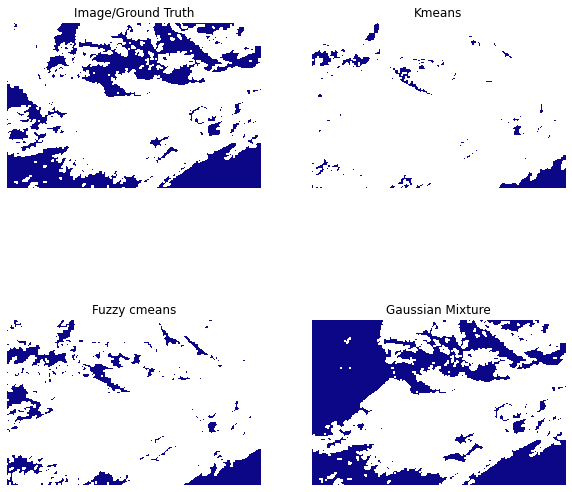

In [7]:
# Reshape del Ground Truth como una imagen
Y_KM = np.reshape(predKM, (X.shape[0], X.shape[1]),order="F") 
Y_fKM = np.reshape(pred_f, (X.shape[0], X.shape[1]),order="F") 
Y_GM = np.reshape(predGM, (X.shape[0], X.shape[1]),order="F") 

clasmapKM=Y_KM; 
clasmap_maskedKM = np.ma.masked_where(clasmapKM<1,clasmapKM)
clasmapfKM=Y_fKM; 
clasmap_maskedfKM = np.ma.masked_where(clasmapfKM<1,clasmapfKM)
clasmapGM=Y_GM; 
clasmap_maskedGM = np.ma.masked_where(clasmapGM<1,clasmapGM)

# Dibujamos los resultados
plt.figure(figsize = (10,10))
ax=plt.subplot(2,2,1)
#ax.imshow(X[:,:,1])
ax.imshow(clasmap_masked, cmap = 'plasma'), ax.axis('off'), plt.title('Image/Ground Truth')
ax=plt.subplot(2,2,2)
#ax.imshow(X[:,:,1])
ax.imshow(clasmap_maskedKM, cmap = 'plasma'), ax.axis('off'), plt.title('Kmeans')
ax=plt.subplot(2,2,3)
#ax.imshow(X[:,:,1])
ax.imshow(clasmap_maskedfKM, cmap = 'plasma'), ax.axis('off'), plt.title('Fuzzy cmeans')
ax=plt.subplot(2,2,4)
#ax.imshow(X[:,:,1])
ax.imshow(clasmap_maskedGM, cmap = 'plasma'), ax.axis('off'), plt.title('Gaussian Mixture')

Obtenemos las siguientes imágenes, donde, para una mejor visualización, hemos obviado la imagen de fondo. A simple vista, podemos ver que el algoritmo de mezcla de gaussianas obtiene un resultado que se parece más a la clasificación real.

Sería posible que al no haber empleado las etiquetas de las clases el mapa de clasificación basado en clustering no tuviera mucha relación con las clases predefinidas. Esto a nosotros no nos ocurre, pues solo tenemos dos clases en nuestra imagen hiperespectral, y todos los algoritmos han acertado con las clases predefinidas.

**Vamos a pasar ahora a aplicar algoritmos de aprendizaje supervisado simulando la escasez de muestras etiquetadas empleando solo 5000 muestras con sus etiquetas. Sin embargo, la selección de estas muestras no la vamos a hacer de forma aleatoria sino que vamos a emplear algoritmos de clustering para reducir el número de muestras pero preservando la distribución de los datos de entrada y de las clases definidas.**  Por tanto, en primer lugar separaremos los datos en función de su etiqueta de clase y en cada subconjunto, aplicaremos algún algoritmo de clustering y definir una estrategia para obtener un subconjunto reducido que sea representativo del conjunto inicial.

Lo primero que hacemos es separar los datos en función de su etiqueta de clase, sabiendo que tenemos píxeles con etiquetas 1 y 0.

In [8]:
# Separemos los datos en función de su etiqueta de clase. Tenemos pixeles con etiquetas 1 y 0

pos_0 = np.where(Yl == 0)
pos_1 = np.where(Yl == 1)

#datos con etiqueta cero
Xl_0 = Xl[pos_0]
#datos con etiqueta uno
Xl_1 = Xl[pos_1]

Una vez hecho esto, nos planteamos qué forma debe tener la selección dentro de esos elementos para tener un conjunto representativo del original. Así, debemos coger elementos de uno y de otro manteniendo la proporción original, que es la siguiente:

In [9]:
print('Porcentaje de cluster con 0s:', Xl_0.shape[0]/(Xl_1.shape[0]+Xl_0.shape[0])*100,'%')
print('Porcentaje de cluster con 1s:', Xl_1.shape[0]/(Xl_1.shape[0]+Xl_0.shape[0])*100,'%')

Porcentaje de cluster con 0s: 54.22898776010565 %
Porcentaje de cluster con 1s: 45.77101223989435 %


Como vemos, el 54% deben ser de las muestras 0 y el 46% de las muestras 1; dado que queremos seleccionar 5000 muestras del conjunto original debemos coger entonces 2700 muestras de la 0 y 2300 de la 1, eligiendo  equitativamente de los clusters que hagamos. Para ello, vamos a usar el algoritmo que antes ya hemos visto que nos da mejor resultado: el Gaussian Mixture. De este modo, lo que nos planteamos en primer lugar es dividir las muestras de 0s en 27 clusters y la de 1s en 23 clusters, para luego coger aleatoriamente 100 muestras de cada grupo elegido. No obstante, nos hemos dado cuenta de que haciendo esto, si los clusters no son muy diferentes los unos de los otros (lo que se puede medir con el valor de silueta), tendríamos que el conjunto que saliese de escoger 100 puntos de cada agrupamiento no tiene por qué ser representativo porque puede ser que los puntos de los diferentes clusters sean iguales.

De este modo lo que hicimos fue calcular el coeficiente de silueta para estos clusters, obteniendo lo siguiente:

In [9]:
#Xl_0
dt = GaussianMixture(n_components = 27, covariance_type='diag', init_params='kmeans' ,tol=0.001, max_iter =300, random_state=0)
etiq_0 = dt.fit_predict(Xl_0)
silhouette_avg_0 = silhouette_score(Xl_0, etiq_0)
print(silhouette_avg_0)

0.23181281713129


In [13]:
#Xl_1
dt = GaussianMixture(n_components = 23, covariance_type='diag', init_params='kmeans' ,tol=0.001, max_iter =300, random_state=0)
etiq_1 = dt.fit_predict(Xl_1)
silhouette_avg_1 = silhouette_score(Xl_1, etiq_1)
print(silhouette_avg_1)

0.3507425793635016


Obtenemos unos coeficientes de silueta muy bajos, lo que implica que el clustering no es bueno. Dados los malos resultados obtenidos, pensamos que lo idóneo era ver para cuántos clusters obtenemos un mejor resultado del coeficiente de silueta, y hacer la división con estos agrupamientos. Comencemos por el cluster de 0s:

In [16]:
clusters = [6,8,10,12,14]
matrix = 'diag'

for cluster in clusters:
    dt = GaussianMixture(n_components = cluster, covariance_type=matrix, init_params='kmeans', max_iter = 300 ,tol=0.001, random_state=0) 
    etiq_0 = dt.fit_predict(Xl_0)
    silhouette_avg_0 = silhouette_score(Xl_0, etiq_0)
    print('Núm clusters:', cluster,',silhouette:',silhouette_avg_0)

Núm clusters: 6 ,silhouette: 0.44758994148953757
Núm clusters: 8 ,silhouette: 0.32479867743911034
Núm clusters: 10 ,silhouette: 0.2137977403872136
Núm clusters: 12 ,silhouette: 0.21877999001780837
Núm clusters: 14 ,silhouette: 0.21676757245586004


Veamos ahora lo que obtenemos con el cluster de 1s:

In [18]:
clusters = [6,8,10,12,14]
matrix = 'diag'

for cluster in clusters:
    dt = GaussianMixture(n_components = cluster, covariance_type=matrix, init_params='kmeans', max_iter = 300 ,tol=0.001, random_state=0) 
    etiq_1 = dt.fit_predict(Xl_1)
    silhouette_avg_1 = silhouette_score(Xl_1, etiq_1)
    print('Núm clusters:', cluster,',silhouette:',silhouette_avg_1)

Núm clusters: 6 ,silhouette: 0.3787554697793881
Núm clusters: 8 ,silhouette: 0.37421070655579697
Núm clusters: 10 ,silhouette: 0.4065831055373917
Núm clusters: 12 ,silhouette: 0.3675840706338275
Núm clusters: 14 ,silhouette: 0.37690510655993514


Por lo tanto, tenemos que los mejores clusterings se dan para, dentro del grupo de los 0s, 6 agrupamientos, mientras que para el grupo de los 1s, 10 agrupamientos. De este modo, cogeríamos aleatoriamente $\frac{2700 \, puntos}{6 \, clusters} = 450 \, puntos$ de cada cluster dentro de los agrupamientos de los 0s, mientras que seleccionaremos al azar $\frac{2300 \, puntos}{10 \, clusters} = 230 \, puntos$ de cada cluster dentro de los agrupamientos de los 1s, tal y como hacemos a continuación.

In [11]:
#Clustering using GaussianMixture algorithm para etiquetas 0
dt = GaussianMixture(n_components = 6, covariance_type='diag', init_params='kmeans' ,tol=0.001, max_iter =300, random_state=0)
etiq_0 = dt.fit_predict(Xl_0)
labels0 = (np.unique(etiq_0))

#Creamos vector de nombres:
Xl_0_clusters=[]
pos0=[]
print('Tamaño Xl_0_clusters: \n')
for label in labels0:
    pos0.append(np.where(etiq_0 == label))#posicion en la que la etiqueta es label
    Xl_0_clusters.append( Xl_0[pos0[label]])
    print(Xl_0_clusters[label].shape)
    
    
    
#Clustering using GaussianMixture algorithm para etiquetas 1
dt = GaussianMixture(n_components = 10, covariance_type='diag', init_params='kmeans', max_iter = 300 ,tol=0.001, random_state=0) 
etiq_1 = dt.fit_predict(Xl_1)
labels1 = (np.unique(etiq_1))

#Creamos vector de nombres:
Xl_1_clusters=[]
pos1=[]
print('Tamaño Xl_1_clusters: \n')
for label in labels1:
    pos1.append(np.where(etiq_1 == label))#posicion en la que la etiqueta es label
    Xl_1_clusters.append( Xl_1[pos1[label]])
    print(Xl_1_clusters[label].shape)

Tamaño Xl_0_clusters: 

(46495, 15)
(1282, 15)
(23084, 15)
(5003, 15)
(8532, 15)
(1423, 15)
Tamaño Xl_1_clusters: 

(13065, 15)
(4138, 15)
(8369, 15)
(8590, 15)
(5169, 15)
(7117, 15)
(9957, 15)
(2713, 15)
(6044, 15)
(7272, 15)


No obstante, probando con otros números de clusters para el conjunto de 0s, nos hemos dado cuenta de que en los siguientes apartados en los que se usan algoritmos de aprendizaje supervisado se obtienen mejores resultados de precisión que usando 6 clusters, a pesar de que, según el coeficiente de silueta, el conjunto más representativo lo deberíamos obtener escogiendo aleatoriamente muestras de los agrupamientos que se obtienen de dividir el conjunto de 0s entre 6 clusters. Así, heurísticamente nos hemos percatado de que la máxima precisión para los siguientes apartados se obtiene agrupando en 10 clusters la muestra de 0s. Hagámoslo, escogiendo aleatoriamente $\frac{2700 \, puntos}{10 \, clusters} = 270 \, puntos$ de cada cluster dentro de los agrupamientos de los 0s, y como antes, seleccionando al azar $\frac{2300 \, puntos}{10 \, clusters} = 230 \, puntos$ de cada cluster dentro de los agrupamientos de los 1s, tal y como hacemos a continuación.



In [10]:
#Clustering using GaussianMixture algorithm para etiquetas 0
dt = GaussianMixture(n_components = 10, covariance_type='diag', init_params='kmeans' ,tol=0.001, max_iter =300, random_state=0)
etiq_0 = dt.fit_predict(Xl_0)
labels0 = (np.unique(etiq_0))

#Creamos vector de nombres:
Xl_0_clusters=[]
pos0=[]
print('Tamaño Xl_0_clusters: \n')
for label in labels0:
    pos0.append(np.where(etiq_0 == label))#posicion en la que la etiqueta es label
    Xl_0_clusters.append( Xl_0[pos0[label]])
    print(Xl_0_clusters[label].shape)
    
    
    
#Clustering using GaussianMixture algorithm para etiquetas 1
dt = GaussianMixture(n_components = 10, covariance_type='diag', init_params='kmeans', max_iter = 300 ,tol=0.001, random_state=0) 
etiq_1 = dt.fit_predict(Xl_1)
labels1 = (np.unique(etiq_1))

#Creamos vector de nombres:
Xl_1_clusters=[]
pos1=[]
print('Tamaño Xl_1_clusters: \n')
for label in labels1:
    pos1.append(np.where(etiq_1 == label))#posicion en la que la etiqueta es label
    Xl_1_clusters.append( Xl_1[pos1[label]])
    print(Xl_1_clusters[label].shape)

Tamaño Xl_0_clusters: 

(26557, 15)
(2294, 15)
(13044, 15)
(9412, 15)
(1923, 15)
(3790, 15)
(20663, 15)
(1510, 15)
(3684, 15)
(2942, 15)
Tamaño Xl_1_clusters: 

(13065, 15)
(4138, 15)
(8369, 15)
(8590, 15)
(5169, 15)
(7117, 15)
(9957, 15)
(2713, 15)
(6044, 15)
(7272, 15)


Aunque no es nuestro caso, podría ser que tuviésemos algunos elementos de la división de los subconjuntos que no llegasen a tener el número de elementos necesarios para tener el mismo número de puntos aleatoriamente escogidos de cada subconjunto (por ejemplo, que en un subconjunto de los 0s hubiese 200 puntos, siendo el número a escoger de cada subgrupo 270). Así, lo que haríamos en estos casos sería escoger aleatoriamente puntos de los otros subconjuntos del mismo tipo (de 0s o de 1s), para  así rellenar hasta los 5000 puntos, teniendo entonces un subconjunto representativo de la muestra original.

In [11]:
#Para puntos con etiqueta 0
RandPos0= []
for i in range(len(Xl_0_clusters)):
    if pos0[i][0].shape[0] < 270:
        RandPos0.append(pos0[i][0])
        RandPos0.append(np.random.choice(pos0[:][0][0], size = 270-pos0[i][0].shape[0], replace = False))
    else:
        RandPos0.append(np.random.choice(pos0[i][0], size = 270, replace = False))
    
RandPos0 = np.concatenate(RandPos0[:])
while np.unique(RandPos0).shape[0]<2700:
     RandPos0 = np.unique(RandPos0)
     RandPos0 = np.concatenate((RandPos0, np.random.choice(pos0[:][0][0], size = 2700-RandPos0.shape[0])))
    
#Para puntos con etiqueta 1
RandPos1= []
for i in range(len(Xl_1_clusters)):
    if pos1[i][0].shape[0] < 230:
        RandPos1.append(pos1[i][0])
        RandPos1.append(np.random.choice(pos1[:][0][0], size = 230-pos1[i][0].shape[0], replace = False))
    else:
        RandPos1.append(np.random.choice(pos1[i][0], size = 230, replace = False))
    
RandPos1 = np.concatenate(RandPos1[:])
while np.unique(RandPos1).shape[0]<2300:
     RandPos1 = np.unique(RandPos1)
     RandPos1 = np.concatenate((RandPos1, np.random.choice(pos1[:][0][0], size = 2300-RandPos1.shape[0])))

Las muestras que cogemos serán las que ocupen las posiciones almacenadas en RandPos1 y RandPos0. Una vez las tenemos, las juntamos todas y así seleccionamos del conjunto original los valores de estas posiciones. Por otro lado, dejamos como conjunto de test el resto de muestras que no pertenecen a este conjunto representativo.

In [12]:
#El conjunto de entrenamiento será:
Xl_0_train = Xl_0[RandPos0,:]
Yl_0_train = np.zeros((Xl_0_train.shape[0],))
Xl_1_train = Xl_1[RandPos1,:]
Yl_1_train = np.ones((Xl_1_train.shape[0],))
Xl_train = np.concatenate((Xl_0_train, Xl_1_train))
Yl_train = np.concatenate((Yl_0_train, Yl_1_train))

#El conjunto de test será:
Xl_0_test = np.delete(Xl_0, RandPos0, axis = 0)
Xl_1_test = np.delete(Xl_1, RandPos1, axis = 0)
Xl_test = np.concatenate((Xl_0_test, Xl_1_test))
Yl_0_test = np.zeros((Xl_0_test.shape[0],))
Yl_1_test = np.ones((Xl_1_test.shape[0],))
Yl_test = np.concatenate((Yl_0_test, Yl_1_test))

Una vez tenemos todo esto, pasamos al siguiente apartado.

**Vamos a pasar ahora a utilizar algoritmos supervisados sobre el conjunto reducido de entrenamiento para obtener la clasificación de la imagen. De este modo, vamos a obtener una aproximación del error de clasificación en test utilizando una partición del conjunto de entrenamiento, así como también resultados cualitativos representado las imágenes de clasificación.**

Una vez obtenido el conjunto de datos de entrenamiento representativo, nos planteamos aplicar algoritmos de aprendizaje supervisado con el objetivo de obtener una clasificación de los píxeles de la imagen hiperespectral con mayor precisión que mediante algoritmos de clústering. Con el fin de comparar los resultados de diferentes algoritmos, aplicamos, por un lado, dos algoritmos del tipo support vector machine (SVM) y, por otro lado, un árbol de decisión.

Comencemos por el algoritmo Support Vector Machine (SVM), el cual es un tipo algoritmo supervisado utilizado tanto en regresión como en clasificación. El objetivo de este tipo de algoritmos es encontrar un hiperplano en un espacio N-dimensional que separe los datos. Para ello, debemos representar nuestros datos, $\textbf{x}$, en un espacio de Hilbert donde estos sean separables mediante un hiperplano. Esto lo conseguimos a través de una aplicación $\phi(\textbf{x})$. La similitud entre las muestras en este espacio de Hilbert viene dada por la función kernel, $K(\textbf{x},\textbf{x'})=\langle\phi(\textbf{x}),\phi(\textbf{x'})\rangle$

Apliquemos el algoritmo SVM de clasificación de la librería sklearn:

In [13]:
from sklearn import svm

clf_svm = svm.SVC(verbose=True, random_state=0)
clf_svm.fit(Xl_train,Yl_train)

#Predecimos para todos los datos (esto lo hacemos para poder hacer posteriormente la representación)
Yl_svm = clf_svm.predict(Xl)
#Predecimos para los datos de test, donde hemos eliminado los de entrenamiento
Yl_svm_test = clf_svm.predict(Xl_test)
#Predecimos para los datos de entrenamiento
Yl_svm_train = clf_svm.predict(Xl_train)

#Veamos los errores:
print("Método SVM:")
print("Datos de test:")
print(classification_report(Yl_test, Yl_svm_test))
print("Datos de entrenamiento: ")
print(classification_report(Yl_train, Yl_svm_train))

[LibSVM]Método SVM:
Datos de test:
              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93     83119
         1.0       0.97      0.86      0.91     70134

    accuracy                           0.92    153253
   macro avg       0.93      0.92      0.92    153253
weighted avg       0.93      0.92      0.92    153253

Datos de entrenamiento: 
              precision    recall  f1-score   support

         0.0       0.91      0.87      0.89      2700
         1.0       0.85      0.89      0.87      2300

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



Vemos que obtenemos una precisión en entrenamiento del 88%, mientras que para el test tenemos una precisión del 92 %, que, tal y como esperábamos, es superior a la obtenida mediante algoritmos de aprendizaje no supervisado. Además, el f1-score de ambas clases es alto.

El siguiente algoritmo aplicado del tipo SVM es el least squares support vector machine (LS-SVM). Este algoritmo transforma un algoritmo de regresión en uno de clasificación aplicando un umbral. El algoritmo de regresión utilizado es el KernelRidge, utilizando como función kernel una gaussiana (rbf). Como tenemos etiquetas 0 y 1, aplicamos un umbral al resultado de 0.5, de modo que si el algoritmo devuelve un valor superior a 0.5 será considerado como 1, y si devuelve un valor menor a 0.5 será considerado como 0.

Para determinar el valor de la constante de regularización que introducimos en el algoritmo de regresión, hacemos uso de cross validation y nos quedamos con el mejor resultado.

In [14]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-3, 1, 5)
clf2 = GridSearchCV(KernelRidge(kernel='rbf'), {'alpha':alphas}, cv=5,n_jobs=-1,verbose=0)
clf2.fit(Xl_train, Yl_train)
clf2=clf2.best_estimator_
print(clf2)

KernelRidge(alpha=0.001, kernel='rbf')


El mejor resultado para la constante de regularización $\alpha$ es 0.001. Hagamos las predicciones y veamos los resultados.

In [15]:
#Predecimos para todos los datos
Yl_krr = clf2.predict(Xl)
etiq0 = np.where(Yl_krr < 0.5) 
Yl_krr[etiq0]=0                 
etiq1 = np.where(Yl_krr > 0.5)
Yl_krr[etiq1]=1

#Predecimos para los datos de test
Yl_krr_test = clf2.predict(Xl_test)
etiq0_test = np.where(Yl_krr_test < 0.5) 
Yl_krr_test[etiq0_test]=0                 
etiq1_test = np.where(Yl_krr_test > 0.5)
Yl_krr_test[etiq1_test]=1

#Predecimos para los datos de entrenamiento
Yl_krr_train = clf2.predict(Xl_train)
etiq0_train = np.where(Yl_krr_train < 0.5) 
Yl_krr_train[etiq0_train]=0                 
etiq1_train = np.where(Yl_krr_train > 0.5)
Yl_krr_train[etiq1_train]=1

#Veamos los resultados
print("Método LS-SVM")
print("Datos de test")
print(classification_report(Yl_test, Yl_krr_test))
print("Datos de entrenamiento")
print(classification_report(Yl_train, Yl_krr_train))

Método LS-SVM
Datos de test
              precision    recall  f1-score   support

         0.0       0.85      0.99      0.92     83119
         1.0       0.99      0.80      0.89     70134

    accuracy                           0.91    153253
   macro avg       0.92      0.90      0.90    153253
weighted avg       0.92      0.91      0.90    153253

Datos de entrenamiento
              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93      2700
         1.0       0.96      0.85      0.91      2300

    accuracy                           0.92      5000
   macro avg       0.92      0.91      0.92      5000
weighted avg       0.92      0.92      0.92      5000



Alcanzamos una precisión en test muy similar al algoritmo anterior, del 91 %, mientras que para el entrenamiento obtenemos una precisión superior, del 92%. Seguimos obteniendo unos valores buenos para la precision y el recall para ambas clases.

Por últmo, apliquemos un árbol de decisión, que va separando los datos con el objetivo de disminuir la entropía. En nuestro caso vamos a usar un árbol de, como máximo, 14 niveles. Hemos elegido este nivel de profundidad debido a que si tomamos un valor mayor se produce sobreentrenamiento. Veamos lo que obtenemos:

In [13]:
from sklearn.tree import DecisionTreeClassifier
mod = DecisionTreeClassifier(criterion='entropy', max_depth= 14, random_state=0)

mod.fit(Xl_train, Yl_train)
Yl_tree = mod.predict(Xl)
Yl_tree_train = mod.predict(Xl_train)
Yl_tree_test = mod.predict(Xl_test)

#Veamos los resultados
print("Datos de test")
print(classification_report(Yl_test,Yl_tree_test))
print("Datos de entrenamiento")
print(classification_report(Yl_train,Yl_tree_train))

Datos de test
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96     83119
         1.0       0.97      0.93      0.95     70134

    accuracy                           0.95    153253
   macro avg       0.96      0.95      0.95    153253
weighted avg       0.96      0.95      0.95    153253

Datos de entrenamiento
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      2700
         1.0       0.98      0.97      0.98      2300

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



Con este algoritmo obtenemos la máxima precisión en test, llegando al 95 %, mientras que la precisión de los datos de entrenamiento es del 98%, siendo también la más alta. También tenemos el f1-score más alto obtenido hasta ahora para ambas clases. Como era de esperar, empleando métodos de aprendizaje supervisado se obtienen precisiones superiores a las obtenidas empleando métodos de aprendizaje no supervisado.

Representemos gráficamente los diferentes resultados obtenidos.

(<matplotlib.image.AxesImage at 0x1b81fcf2070>,
 (-0.5, 492.5, 320.5, -0.5),
 Text(0.5, 1.0, 'Decision Tree'))

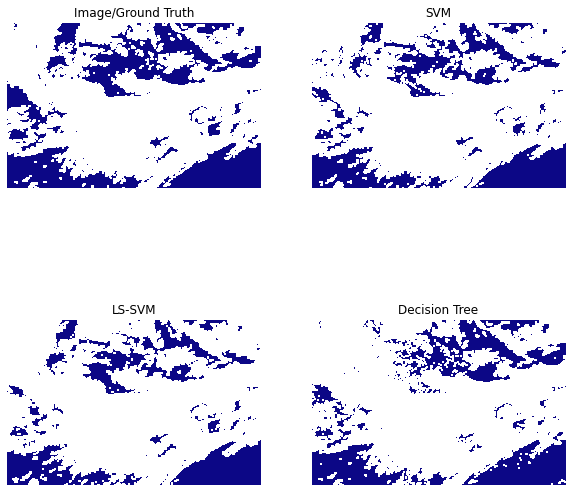

In [17]:
# Reshape del Ground Truth como una imagen
Y_svm = np.reshape(Yl_svm, (X.shape[0], X.shape[1]),order="F") 
Y_krr = np.reshape(Yl_krr, (X.shape[0], X.shape[1]),order="F") 
Y_tree = np.reshape(Yl_tree, (X.shape[0], X.shape[1]),order="F") 

clasmapsvm=Y_svm; 
clasmap_maskedsvm = np.ma.masked_where(clasmapsvm<1,clasmapsvm)
clasmapkrr=Y_krr; 
clasmap_maskedkrr = np.ma.masked_where(clasmapkrr<1,clasmapkrr)
clasmaptree=Y_tree; 
clasmap_maskedtree = np.ma.masked_where(clasmaptree<1,clasmaptree)

# Dibujamos los resultados
plt.figure(figsize = (10,10))
ax=plt.subplot(2,2,1)
#ax.imshow(X[:,:,1])
ax.imshow(clasmap_masked, cmap = 'plasma'), ax.axis('off'), plt.title('Image/Ground Truth')
ax=plt.subplot(2,2,2)
#ax.imshow(X[:,:,1])
ax.imshow(clasmap_maskedsvm, cmap = 'plasma'), ax.axis('off'), plt.title('SVM')
ax=plt.subplot(2,2,3)
#ax.imshow(X[:,:,1])
ax.imshow(clasmap_maskedkrr, cmap = 'plasma'), ax.axis('off'), plt.title('LS-SVM')
ax=plt.subplot(2,2,4)
#ax.imshow(X[:,:,1])
ax.imshow(clasmap_maskedtree, cmap = 'plasma'), ax.axis('off'), plt.title('Decision Tree')

Como hemos visto arriba, todas los resultados obtenidos con los diferentes algoritmos de clasificación tienen una precisión alta, lo que provoca que todas las imágenes se parezcan mucho a la realidad.

**Es posible que la imagen tenga bandas con datos erróneos, o con bandas que tengan poca relevancia en el resultado de la clasificación. Utilizando métodos de clasificación que proporcionen un 'ranking' de características vamos a tratar de detectar y eliminar aquellas bandas que empeoran (o no mejoran) el resultado de la clasificación.**

El objetivo de este apartado es cobtener qué bandas tienen poca relevancia, quitarlas de nuestros datos y ver el resultado obtenido. Para ello, comenzando con los algoritmos de aprendizaje supervisado SVM y LS-SVM, vamos a usar el algoritmo *permutation_importance*, de *sklearn.inspection*. Este algoritmo nos da la importancia de las diferentes características (en este caso bandas) calculando cómo varía el resultado del algoritmo si se permutan las diferentes capas; de este modo, si al cambiar una capa el resultado cambia bastante implica que esa capa es importante, mientras que si no cambia prácticamente nada implica que esa capa no aporta demasiada información, o lo que es lo mismo, no es muy importante. Siendo más concretos, la importancia de la permutación de una característica se calcula como sigue: en primer lugar, se evalúa una métrica de referencia, definida por scoring, en un conjunto de datos (potencialmente diferente) que llamamos X. A continuación, se permuta una columna de características del conjunto de validación y se evalúa de nuevo la métrica. La importancia de la permutación se define como la diferencia entre la métrica de referencia y la métrica de la permutación de la columna de características.

### SVM

Veamos lo que ocurre para el método SVM cuando le aplicamos esta función:

Text(0.5, 1.0, 'SVM')

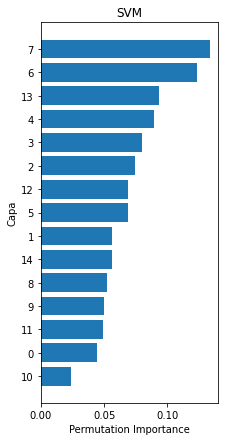

In [36]:
from sklearn.inspection import permutation_importance

## SVM
per_impSVM = permutation_importance(clf_svm, Xl_train, Yl_train, n_jobs = -1, random_state = 0)
sorted_idxSVM = per_impSVM.importances_mean.argsort()

n_features = 15
feat = []
for i in range(n_features):
    feat.append(str(i))
features = np.array(feat)

plt.figure(figsize=(7,7))
ax = plt.subplot(1,2,1)
ax.barh(features[sorted_idxSVM], per_impSVM.importances_mean[sorted_idxSVM])
ax.set_xlabel("Permutation Importance")
ax.set_ylabel("Capa")
ax.set_title('SVM')


Para cada algoritmo, las diferentes capas tendrán diferentes importancias. Así, para el SVM, vamos a eliminar las capas 10,0,11,9,8, puesto que estas capas son las menos importantes en este método.

In [11]:
var_drop_SVM = np.array([10,0,11,9,8])
Xl_drop_SVM = np.delete(Xl, var_drop_SVM, axis = 1)
Xl_train_drop_SVM = np.delete(Xl_train, var_drop_SVM, axis = 1)
Xl_test_drop_SVM = np.delete(Xl_test, var_drop_SVM, axis = 1)

Veamos ahora los errores cuantitativos que obtenemos para el algoritmo SVM:

In [14]:
#SVM
clf = svm.SVC(verbose=True, random_state=0)
clf.fit(Xl_train_drop_SVM,Yl_train)

#Calculamos la predicción para todos los datos para luego representar
Yl_svm_drop = clf.predict(Xl_drop_SVM)
#Predecimos para los datos de entrenamiento
Yl_svm_train_drop = clf.predict(Xl_train_drop_SVM)
#Predecimos para los datos de test, donde hemos eliminado los de entrenamiento
Yl_svm_test_d = clf.predict(Xl_test_drop_SVM)

#Veamos los errores:
print("Método SVM:")
print("Datos de entrenamiento:")
print(classification_report(Yl_train,Yl_svm_train_drop))
print("Datos de test:")
print(classification_report(Yl_test, Yl_svm_test_d)) 

[LibSVM]Método SVM:
Datos de entrenamiento:
              precision    recall  f1-score   support

         0.0       0.90      0.86      0.88      2700
         1.0       0.84      0.89      0.87      2300

    accuracy                           0.87      5000
   macro avg       0.87      0.88      0.87      5000
weighted avg       0.88      0.87      0.87      5000

Datos de test:
              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93     83119
         1.0       0.97      0.86      0.91     70134

    accuracy                           0.92    153253
   macro avg       0.93      0.92      0.92    153253
weighted avg       0.92      0.92      0.92    153253



Obtenemos una precisión para los datos de entrenamiento de un 87%, mientras que para los datos de test obtenemos una precisión del 92%. Comparando con las precisiones que obteníamos antes de quitar las capas menos importantes, vemos que son exactamente las mismas. 

Veamos ahora la comparación cualitativa mediante la representación gráfica antes de quitar las capas no informativas y después:


(<matplotlib.image.AxesImage at 0x7f881826c3d0>,
 (-0.5, 492.5, 320.5, -0.5),
 Text(0.5, 1.0, 'SVM without non-important features'))

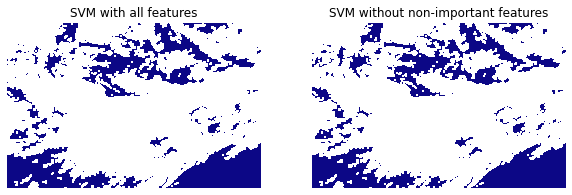

In [17]:
Y_svm = np.reshape(Yl_svm, (X.shape[0], X.shape[1]),order="F") 
clasmap4=Y_svm; #aqui deberiamos poner nuestra clasificacion
clasmap_masked4 = np.ma.masked_where(clasmap4<1,clasmap4)

Y_svm_drop = np.reshape(Yl_svm_drop, (X.shape[0], X.shape[1]),order="F") 
clasmap5=Y_svm_drop; #aqui deberiamos poner nuestra clasificacion
clasmap_masked5 = np.ma.masked_where(clasmap5<1,clasmap5)

plt.figure(figsize=(10,10))
ax1=plt.subplot(1,2,1)
#ax1.imshow(X[:,:,1])
ax1.imshow(clasmap_masked4,cmap = 'plasma'), ax1.axis('off'), plt.title('SVM with all features')
ax1=plt.subplot(1,2,2)
#ax1.imshow(X[:,:,1])
ax1.imshow(clasmap_masked5,cmap = 'plasma'), ax1.axis('off'), plt.title('SVM without non-important features')

Vemos que ambas representaciones son muy similares la una de la otra; no se aprecian diferencias significativas.

### LS-SVM

Veamos ahora lo que ocurre con el LS-SVM:

Text(0.5, 1.0, 'LS-SVM')

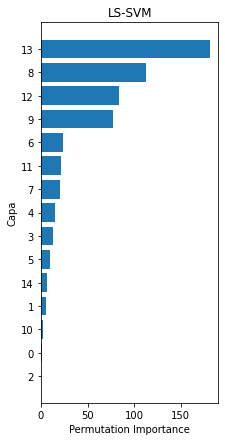

In [39]:
## LS-SVM
per_impKRR = permutation_importance(clf2, Xl_train, Yl_train, n_jobs = -1, random_state = 0)
sorted_idxKRR = per_impKRR.importances_mean.argsort()

plt.figure(figsize=(7,7))
ax = plt.subplot(1,2,1)
ax.barh(features[sorted_idxKRR], per_impKRR.importances_mean[sorted_idxKRR])
ax.set_xlabel("Permutation Importance")
ax.set_ylabel("Capa")
ax.set_title('LS-SVM')

Para este algoritmo, las capas menos importantes son la 0,2,10,1,14 y la 5. Quitémoslas:

In [19]:
var_drop_LS = np.array([0,2,10,1,14,5])
Xl_drop_LS = np.delete(Xl, var_drop_LS, axis = 1)
Xl_train_drop_LS = np.delete(Xl_train, var_drop_LS, axis = 1)
Xl_test_drop_LS = np.delete(Xl_test, var_drop_LS, axis = 1)

Veamos los errores cuantitativos para este método:

In [21]:
clf2.fit(Xl_train_drop_LS, Yl_train)


#Predecimos para todos los datos para representar luego
Yl_krr_drop = clf2.predict(Xl_drop_LS)
etiq0 = np.where(Yl_krr_drop < 0.5) 
Yl_krr_drop[etiq0]=0                 
etiq1 = np.where(Yl_krr_drop > 0.5)
Yl_krr_drop[etiq1]=1

#Predecimos para los datos de test
Yl_krr_test = clf2.predict(Xl_test_drop_LS)
etiq0_test = np.where(Yl_krr_test < 0.5) 
Yl_krr_test[etiq0_test]=0                 
etiq1_test = np.where(Yl_krr_test > 0.5)
Yl_krr_test[etiq1_test]=1

#Predecimos para los datos de entrenamiento
Yl_krr_train = clf2.predict(Xl_train_drop_LS)
etiq0_train = np.where(Yl_krr_train < 0.5) 
Yl_krr_train[etiq0_train]=0                 
etiq1_train = np.where(Yl_krr_train > 0.5)
Yl_krr_train[etiq1_train]=1

#Veamos los resultados
print("Método LS-SVM")
print("Datos de test")
print(classification_report(Yl_test, Yl_krr_test))
print("Datos de entrenamiento")
print(classification_report(Yl_train, Yl_krr_train))

Método LS-SVM
Datos de test
              precision    recall  f1-score   support

         0.0       0.85      0.99      0.92     83119
         1.0       0.99      0.79      0.88     70134

    accuracy                           0.90    153253
   macro avg       0.92      0.89      0.90    153253
weighted avg       0.91      0.90      0.90    153253

Datos de entrenamiento
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.93      2700
         1.0       0.96      0.85      0.90      2300

    accuracy                           0.92      5000
   macro avg       0.92      0.91      0.91      5000
weighted avg       0.92      0.92      0.91      5000



Para el LS-SVM, obtenemos una precisión para los datos de entrenamiento de un 92%, mientras que para los datos de test obtenemos una precisión del 90%. Comparando con las precisiones que obteníamos antes de quitar las capas menos importantes, vuelve a ocurrir que son exactamente las mismas. Veamos ahora, como antes, el posible error cualitativo de este método al haber quitado las capas menos importantes mediante la comparación de las imágenes antes y después de quitar las capas menos importantes.



(<matplotlib.image.AxesImage at 0x7f88181ac6a0>,
 (-0.5, 492.5, 320.5, -0.5),
 Text(0.5, 1.0, 'LS-SVM without non-important features'))

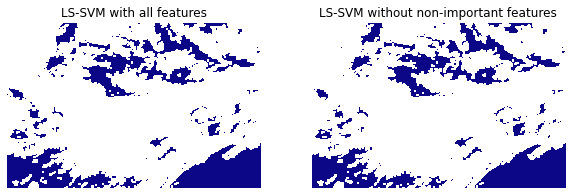

In [26]:
Y_krr = np.reshape(Yl_krr, (X.shape[0], X.shape[1]),order="F") 
clasmapkrr=Y_krr; 
clasmap_maskedkrr = np.ma.masked_where(clasmapkrr<1,clasmapkrr)

Y_ls_drop = np.reshape(Yl_krr_drop, (X.shape[0], X.shape[1]),order="F") 
clasmap5=Y_ls_drop; #aqui deberiamos poner nuestra clasificacion
clasmap_masked5 = np.ma.masked_where(clasmap5<1,clasmap5)


# Dibujamos los resultados
plt.figure(figsize = (10,10))
ax=plt.subplot(1,2,1)
ax.imshow(clasmap_maskedkrr, cmap = 'plasma'), ax.axis('off'), plt.title('LS-SVM with all features')
ax1=plt.subplot(1,2,2)
ax1.imshow(clasmap_masked5,cmap = 'plasma'), ax1.axis('off'), plt.title('LS-SVM without non-important features')

Como antes, tenemos que no se aprecian diferencias significativas entre una imagen y la otra; esto nos dice que, a pesar de haber quitado unas capas, como no son significativas, no afectan al funcionamiento de nuestro algoritmo.

### DecisionTree

Pasemos ahora a ver lo que ocurre con el Decision Tree. Para este algoritmo se puede ver la importancia de las diferentes capas usando el atributo *feature_importances_* en lugar del comando *permutation_importance*. La importancia de una característica se calcula como la reducción total (normalizada) del criterio aportado por esa característica. También se conoce como la importancia de Gini. No obstante, La importancia de las características basadas en impurezas puede ser engañosa para características de alta cardinalidad (es decir, con muchos valores únicos). Así, dado que este atributo funciona de una manera similar a como lo hace el comando antes utilizado, vamos a elegir las capas que quitar teniendo en cuenta lo que nos dan ambos algoritmos.

Text(0.5, 1.0, 'DecisionTree with feature_importances')

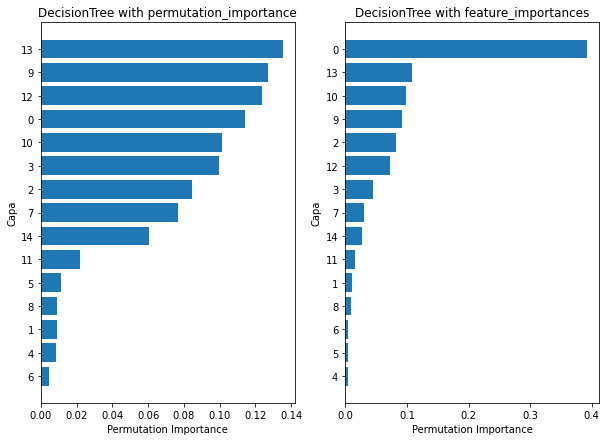

In [14]:
#Con metodo de antes:
from sklearn.inspection import permutation_importance
mod = DecisionTreeClassifier(criterion='entropy', max_depth= 14, random_state=0)
mod.fit(Xl_train, Yl_train)
per_tree = permutation_importance(mod, Xl_train, Yl_train, n_jobs = -1, random_state = 0)
sorted_tree = per_tree.importances_mean.argsort()

#Con atributo de DecisionTree
importances = mod.feature_importances_
index_sorted = np.argsort(importances)

#Representamos
n_features = 15
feat = []
for i in range(n_features):
    feat.append(str(i))
features = np.array(feat)

plt.figure(figsize=(10,7))
ax = plt.subplot(1,2,1)
ax.barh(features[sorted_tree], per_tree.importances_mean[sorted_tree])
ax.set_xlabel("Permutation Importance")
ax.set_ylabel("Capa")
ax.set_title('DecisionTree with permutation_importance')

ax = plt.subplot(1,2,2)
ax.barh(features[index_sorted], importances[index_sorted])
ax.set_xlabel("Permutation Importance")
ax.set_ylabel("Capa")
ax.set_title('DecisionTree with feature_importances')


Observamos que con ambos métodos las capas menos importantes y las más importantes coinciden. Decidimos por tanto quitar las capas 6, 4, 5, 8,1 y 12.

In [15]:
var_drop_tree = np.array([6, 4, 5, 8,1 , 12])
Xl_drop_tree = np.delete(Xl, var_drop_tree, axis = 1)
Xl_train_drop_tree = np.delete(Xl_train, var_drop_tree, axis = 1)
Xl_test_drop_tree = np.delete(Xl_test, var_drop_tree, axis = 1)

Veamos ahora los errores cuantitativos que obtenemos ahora tras haber quitado las capas menos significativas:

In [16]:
#TREES
mod.fit(Xl_train_drop_tree,Yl_train)

#Calculamos la predicción para todos los datos para luego representar
Yl_tree_drop = mod.predict(Xl_drop_tree)
#Predecimos para los datos de entrenamiento
Yl_tree_train_drop = mod.predict(Xl_train_drop_tree)
#Predecimos para los datos de test, donde hemos eliminado los de entrenamiento
Yl_tree_test_drop = mod.predict(Xl_test_drop_tree)

#Veamos los errores:
print("Método DecisionTree:")
print("Datos de entrenamiento:")
print(classification_report(Yl_train,Yl_tree_train_drop))
print("Datos de test:")
print(classification_report(Yl_test, Yl_tree_test_drop)) 

Método DecisionTree:
Datos de entrenamiento:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      2700
         1.0       0.97      0.98      0.97      2300

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000

Datos de test:
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96     83119
         1.0       0.97      0.93      0.95     70134

    accuracy                           0.95    153253
   macro avg       0.96      0.95      0.95    153253
weighted avg       0.95      0.95      0.95    153253



Para el DecisionTree, al igual que antes, obtenemos la misma precisión en test después de haber quitado las capas menos importantes que antes de eliminarlas, siendo de un 95%. Por otro lado, para los datos de entrenamiento obtenemos una precisión de un 98 %, la cual sigue siendo la misma que antes.

Veamos ahora, como antes, el posible error cualitativo de este método al haber quitado las capas menos importantes mediante la comparación de las imágenes antes y después de quitar las capas menos importantes.

(<matplotlib.image.AxesImage at 0x1b827d07220>,
 (-0.5, 492.5, 320.5, -0.5),
 Text(0.5, 1.0, 'DecisionTree without non-important features'))

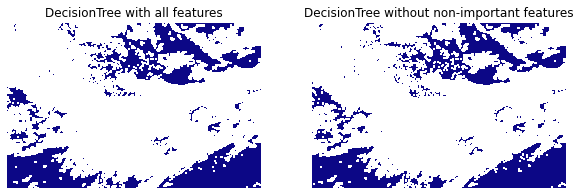

In [21]:
Y_tree = np.reshape(Yl_tree, (X.shape[0], X.shape[1]),order="F") 
clasmaptree=Y_tree; 
clasmap_maskedtree = np.ma.masked_where(clasmaptree<1,clasmaptree)

Y_tree_drop = np.reshape(Yl_tree_drop, (X.shape[0], X.shape[1]),order="F") 
clasmap5=Y_tree_drop; #aqui deberiamos poner nuestra clasificacion
clasmap_masked5 = np.ma.masked_where(clasmap5<1,clasmap5)


# Dibujamos los resultados
plt.figure(figsize = (10,10))
ax=plt.subplot(1,2,1)
ax.imshow(clasmap_maskedtree, cmap = 'plasma'), ax.axis('off'), plt.title('DecisionTree with all features')
ax1=plt.subplot(1,2,2)
ax1.imshow(clasmap_masked5,cmap = 'plasma'), ax1.axis('off'), plt.title('DecisionTree without non-important features')

Al igual que antes, a simple vista no se ve una diferencia significativa entre la imagen antes de quitar las capas menos importantes y después de hacerlo.

**En último lugar, empleando solo el conjunto reducido de muestras etiquetadas y las bandas seleccionadas, vamos a probar alguna estrategia de combinación de clasificadores (métodos 'ensemble') para intentar mejorar los resultados de la clasificación.**


Para este ejercicio, usaremos métodos ensamble para realizar la clasificación de la imagen. Como predictor débil utilizaremos un árbol de decisión de un solo nivel. Además, emplearemos únicamente las capas que hemos usado en el apartado anterior para este tipo de clasificador. 

Los métodos ensamble consisten en realizar múltiples entrenamientos de un predictor débil y usar como predictor final un conjunto de todos ellos, de modo que se obtiene una mejora significativa con respecto a un único predictor. Un predictor débil, en términos de clasificación, es un modelo que a la hora de clasificar nos da resultados ligeramente mejores que si lo hiciésemos al azar, o lo que es lo mismo, es un clasificador con una precisión ligeramente superior al 50%.

Para ilustrar el método, veamos los resultados que ofrece nuestro predictor débil cuando actúa de forma individual.

In [25]:
predictor = DecisionTreeClassifier
criterion = 'entropy'
max_depth = 1
report = metrics.classification_report

# Creamos el predictor
dt = predictor(criterion=criterion,
               max_depth=max_depth, random_state=0)
#Entrenamos y predecimos, con los datos con las capas más significativas
dt.fit(Xl_train_drop_tree, Yl_train)
yt_train = dt.predict(Xl_train_drop_tree)
yt_test = dt.predict(Xl_test_drop_tree)
print("Datos de entrenamiento")
print(report(Yl_train, yt_train))
print("Datos de test")
print(report(Yl_test, yt_test))

Datos de entrenamiento
              precision    recall  f1-score   support

         0.0       0.91      0.74      0.81      2700
         1.0       0.75      0.91      0.82      2300

    accuracy                           0.82      5000
   macro avg       0.83      0.82      0.82      5000
weighted avg       0.83      0.82      0.82      5000

Datos de test
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     83119
         1.0       0.92      0.84      0.88     70134

    accuracy                           0.90    153253
   macro avg       0.90      0.89      0.89    153253
weighted avg       0.90      0.90      0.90    153253



Vemos que con un único árbol obtenemos una precisión del 82 y 90 por ciento en los datos  de entrenamiento y test, respectivamente.

### Bagging

El método bagging consiste en generar diferentes conjuntos de datos de entrenamiento para entrenar el modelo. Esto lo hacemos seleccionando aleatoriamente y con repetición del conjunto inicial de entrenamiento. El modelo se entrena con los diferentes conjuntos de datos y, como estamos ante un problema de clasificación, la etiqueta final de un píxel será la moda de los resultados obtenidos por cada uno de los predictores.

In [27]:
# Usaremos un total de 500 predictores
T = 500 
# En la variable bag almacenamos los diferentes árboles
bag = list()

# loop for the number of trees
for i in range(0,T):
    Xl_trb, Yl_trb = resample(Xl_train_drop_tree, Yl_train, n_samples = 5000, replace=True) #resampleamos con repetición
    dt = predictor(criterion=criterion,
               max_depth=max_depth) #Nótese que no fijamos el random_state
    bag.append(dt.fit(Xl_trb, Yl_trb)) #Guardamos el modelo entrenado
    
#Hacemos las predicciones para los datos de test y los de entrenamiento
bag_pred_test = np.empty((Xl_test_drop_tree.shape[0],T)) #Metemos en cada columna una predicción
for i in range(0,T):
    bag_pred_test[:,i] = bag[i].predict(Xl_test_drop_tree)
    
bag_pred_train = np.empty((Xl_train_drop_tree.shape[0],T)) #Metemos en cada columna una predicción
for i in range(0,T):
    bag_pred_train[:,i] = bag[i].predict(Xl_train_drop_tree)

#Calculamos la moda de cada una de las filas de bag_pred
yp_bagg_test = mode(bag_pred_test, axis = 1).mode
yp_bagg_train = mode(bag_pred_train, axis = 1).mode

#Veamos el resultado
print("Datos de entrenamiento")
print(report(Yl_train, yp_bagg_train))
print("Datos de test")
print(report(Yl_test, yp_bagg_test))

Datos de entrenamiento
              precision    recall  f1-score   support

         0.0       0.90      0.74      0.81      2700
         1.0       0.75      0.91      0.82      2300

    accuracy                           0.82      5000
   macro avg       0.83      0.82      0.82      5000
weighted avg       0.83      0.82      0.82      5000

Datos de test
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.91     83119
         1.0       0.92      0.84      0.88     70134

    accuracy                           0.90    153253
   macro avg       0.90      0.89      0.89    153253
weighted avg       0.90      0.90      0.89    153253



Comparando con los datos del predictor débil inicial, no observamos mejora al aplicar bagging.

### Random forest

El método random forest funciona de forma similar al método bagging, aunque en este caso se usan siempre árboles como predictores débiles. En este caso, para entrenar cada uno de los árboles, seleccionamos aleatoriamente y con repetición entre las diferentes muestras de entrenamiento y, en cada árbol, seleccionamos unas variables diferentes para hacer el entrenamiento. En nuestro caso, hemos seleccionado para entrenar cada árbol un número de variables máximas igual a la raíz cuadrada del número total de variables.

Además, para tener otra medida del error de del clasificador, predecimos también con los datos que dejamos fuera en cada selección aleatoria y con repetición de muestras, de modo que en el entrenamiento de cada árbol disponemos de un error de test. A esta medida de error se le conoce como out-of-bag error.

In [32]:
# Train RF ensemble (Random Forest)
T = 500
bag = []
idx = np.arange(len(Yl_train))
preds_oob = np.nan * np.ones((len(Yl_train), T)) #matriz de NaN, donde almacenamos las predicciones out-of-bag

for t in range(T):
    idx_trn = resample(idx, replace=True) 
    idx_tst = np.setdiff1d(idx, idx_trn) #Devuelve los valores de idx que no están en idx_trn
    
    model = predictor(criterion=criterion,
                      max_depth=max_depth,
                      max_features='sqrt') #En cada modelo seleccionamos un número de variables
    model.fit(Xl_train_drop_tree[idx_trn,:],Yl_train[idx_trn])
    preds_oob[idx_tst,t] = model.predict(Xl_train_drop_tree[idx_tst,:]) #Predicción para los datos out-of-bag
    bag.append(model)
    
# Prediction OOB
yoob = mode(preds_oob, axis=1, nan_policy='omit').mode #Calcula la moda ignorando los NaN
print('Res RF OOB: ', report(Yl_train, yoob))

# Test
# Obtenemos las T predicciones para los datos de entrenamiento y de test
preds_test = np.zeros((len(Yl_test), T))
for t in range(T):
    preds_test[:,t] = bag[t].predict(Xl_test_drop_tree)
    
preds_train = np.zeros((len(Yl_train), T))
for t in range(T):
    preds_train[:,t] = bag[t].predict(Xl_train_drop_tree)

# Para clasificar, empleamos la moda de cada fila
yp_RF_test = mode(preds_test, axis=1).mode
yp_RF_train = mode(preds_train, axis=1).mode

# Evaluate and compare results
print("Datos de entrenamiento")
print(report(Yl_train, yp_RF_train))
print("Datos de test")
print(report(Yl_test, yp_RF_test))

Res RF OOB:                precision    recall  f1-score   support

         0.0       0.90      0.71      0.80      2700
         1.0       0.73      0.91      0.81      2300

    accuracy                           0.80      5000
   macro avg       0.82      0.81      0.80      5000
weighted avg       0.82      0.80      0.80      5000

Datos de entrenamiento
              precision    recall  f1-score   support

         0.0       0.91      0.71      0.80      2700
         1.0       0.73      0.91      0.81      2300

    accuracy                           0.81      5000
   macro avg       0.82      0.81      0.81      5000
weighted avg       0.83      0.81      0.81      5000

Datos de test
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     83119
         1.0       0.92      0.85      0.88     70134

    accuracy                           0.90    153253
   macro avg       0.90      0.89      0.90    153253
weighted avg       0.90 

Empleando el método de ensemble Random Forest tampoco obtenemos mucha mejoría con respecto a los resultados obtenidos con el predictor débil.

### Adaboost

El método Adaboost consiste en formar un predictor fuerte mediante la combinación de diferentes predictores débiles, cada uno de ellos con un peso diferente. El método consiste en ir añadiendo predictores débiles a nuestro predictor fuerte y actualizando los pesos de las muestras de entrenamiento de modo que aumente en las muestras donde el predictor falla. Para combinar los diferentes predictores débiles, asignamos un peso mayor a los predictores que obtienen un mejor resultado.

Inicialmente, a todas las muestras de entrenamiento les asignamos el mismo peso (vector w en el código). Estos pesos se van actualizando al añadir cada nuevo predictor débil, de modo que aumenta en las muestras más difíciles de clasificar. El vector alpha del código contiene los pesos de cada predictor débil, que es mayor para los predictores débiles que dan mejor resultado.

Usaremos una combinación de 40 predictores débiles.

In [40]:
#Para una correcta implementación, cambiamos las etiquetas 0 por -1
Yl_train=np.intc(Yl_train)
Yl_train[Yl_train == 0] = -1
Yl_test = np.intc(Yl_test)
Yl_test[Yl_test==0]=-1

T = 40 #Número de predictores débiles

#Inicializamos pesos, tanto de muestras como de predictores
N = Xl_train_drop_tree.shape[0] #Número de datos de entrenamiento
alpha = np.empty((T,1)) #Pesos de los predictores
w = np.ones(N)*(1/N) #Pesos de las muestras (inicialmente, todos 1/N)

# Entrenamos los diferentes predictores débiles, que almacenamos en bagAB
bagAB = []
for i in range(0,T):
    dt = predictor(criterion=criterion, max_depth=max_depth)
    dt.fit(Xl_train_drop_tree, Yl_train,sample_weight= w)
    bagAB.append(dt)
    pred = dt.predict(Xl_train_drop_tree)
    epsilon = np.sum(w[Yl_train != pred])
    beta = epsilon/(1-epsilon)
    alpha[i] = np.log(1/beta)
    iok = Yl_train == pred    #Vector booleano que contiene las posiciones de las muestras donde el modelo acierta
    w[iok]=w[iok]*beta
    w = w/np.sum(w) #Normalizado

# Predicciones en entrenamiento y test
# Calculamos la predicción de cada uno de los predictores débiles
preds_train = np.zeros((len(Yl_train),T))
for t,model in enumerate(bagAB):
    preds_train[:,t] =bagAB[t].predict(Xl_train_drop_tree)  
# Calculamos la predicción de cada uno de los predictores débiles
preds_test = np.zeros((len(Yl_test),T))
for t,model in enumerate(bagAB):
    preds_test[:,t] =bagAB[t].predict(Xl_test_drop_tree)  

#Pesamos cada prediccón por el valor del peso del predictor débil que la genera
predAB_train= np.sum(np.dot(preds_train,alpha), axis = 1)
predAB_test = np.sum(np.dot(preds_test,alpha), axis = 1)

#Asignamos una clase u otra según el signo de predAB (por este motivo hemos cambiado las etiquetas 0 por 1)
yp_AB_train = np.sign(predAB_train) 
yp_AB_test = np.sign(predAB_test) 

#Resultados
print("Datos de entrenamiento")
print(report(Yl_train,yp_AB_train))
print("Datos de test")
print(report(Yl_test,yp_AB_test))

Datos de entrenamiento
              precision    recall  f1-score   support

          -1       0.97      0.79      0.87      2700
           1       0.80      0.98      0.88      2300

    accuracy                           0.88      5000
   macro avg       0.89      0.88      0.88      5000
weighted avg       0.89      0.88      0.88      5000

Datos de test
              precision    recall  f1-score   support

          -1       0.98      0.95      0.96     83119
           1       0.94      0.97      0.96     70134

    accuracy                           0.96    153253
   macro avg       0.96      0.96      0.96    153253
weighted avg       0.96      0.96      0.96    153253



Observamos que con este método la precisión en test aumenta considerablemente, alcanzando un 96 %. La predicción en los datos de entrenamiento es menor, con un 88 %

Resumiendo lo visto en este apartado, hemos constatado que empleando los métodos de ensemble Bagging y Random Forest los resultados, comparándolos con los obtenidos con el predictor inicial débil, no mejoran en nada. Por otro lado, si usamos el método de ensemble AdaBoost, sí que obtenemos mejoras significativas con respecto a los resultados iniciales del predictor débil.

En este punto nos preguntamos por qué puede ser que los dos primeros métodos no hayan mejorado los resultados del primer predictor débil, y la respuesta es que realmente el predictor que hemos escogido como débil no lo es. Un predictor débil, como hemos visto al inicio de este apartado, tiene una precisión ligeramente mejor que 50 %, mientras que el decision Tree que hemos empleado nosotros tiene una precisión superior al 80 %. Esto puede provocar que el resultado obtenido no mejore el resultado del predictor débil puesto que este no lo es realmente.